# **CIFAR10**

In this notebook you will explore different methods for avoiding overfitting and improving accuracy when using [Convolutional Neural Networks](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html).

**Task:**

- Please follow the instructions complete all the missing code.
- Questions (marked with QUESTION tag) requires you to answer the posed question with a short and concise answer.

**Note:**

- Keep in mind that there are multiple ways to solve implement some part or answer some questions.
- If you need any help use the [Tensorflow Documentation](https://www.tensorflow.org/) or the [Keras Documentation](https://keras.io)
- Be creative! The data augmentation task gives you a lot of freedom to try out your ideas for best data augmentation techniques. But please keep in mind that you should be able to explain the reasoning behind your decisions.
- In case of blocking problems you can ask for help during our Q&A sessions or discuss it with other students in the slack channel.

### Prerequisites

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. We will divide the dataset into 40,000 training images, 10,000 validation images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(dataset_images, dataset_labels), (test_images, test_labels) = datasets.cifar10.load_data()
num_classes = 10

# TODO: Split the dataset using 80% 10% 10% split.
# That means you want to end up with 40k training, 10k validation
# and 10k test samples
# NOTE: If you prefer to do the train/validation split using the keras api later
# you are free to do so

dataset_size = dataset_images.shape[0]

from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(dataset_images, dataset_labels, train_size=40000)

# TODO: Normalize pixel values to be between 0 and 1
train_images, val_images, test_images = train_images / 255.0, val_images / 255.0, test_images / 255.0

assert train_images.shape == (40000, 32, 32, 3)
assert val_images.shape == (10000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)

### Explore the dataset

To get a better intuition about the data we are using it is always good to inspect the dataset and look at some examples.
Let's plot a couple of images for every class label.


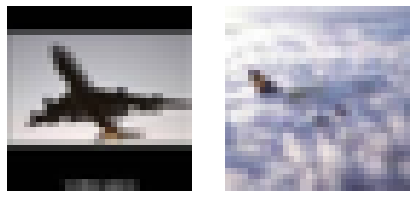

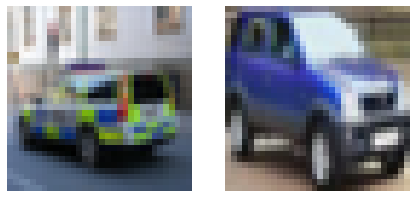

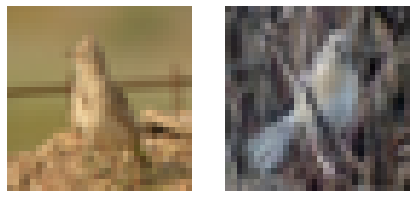

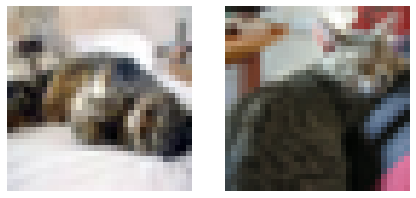

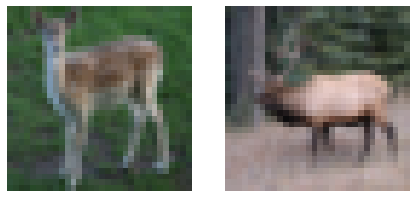

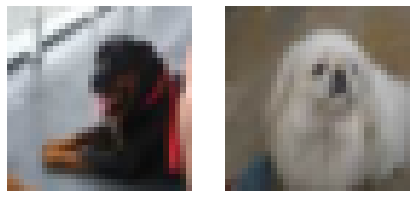

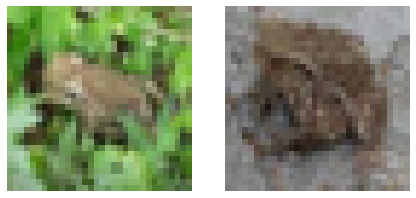

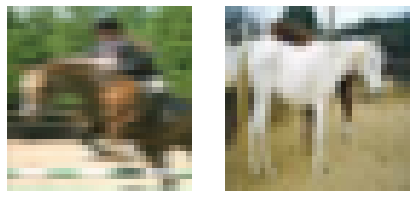

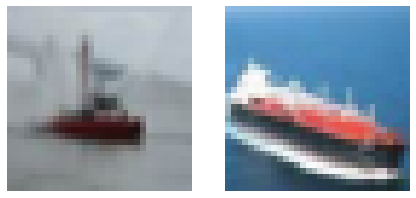

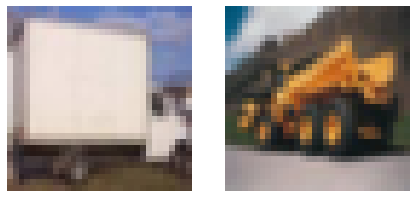

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# TODO: plot two images from the dataset for each of the class names
for i in range(len(class_names)):
    for j, index in enumerate(np.delete(np.argwhere(train_labels == i), 1)[:2]):
        plt.subplot(1, 2, j+1)
        plt.tight_layout()
        plt.axis("off")
        plt.imshow(train_images[index])
    plt.show()


### Create the CNN model

Below you see a method to create our baseline CNN model. It is based on stacking of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) with ReLU activations and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

Usually a CNN takes input of shape (image_height, image_width, channels), ignoring the batch size. The channels refers to color channels in the images (R,G,B). CIFAR images have the shape (32, 32, 3). To accomodate this we are passing the argument `input_shape` to the first layer.

Finally to arrive at the laste dense layer with shape (num_classes), we need to flatten the output of the last pooling layer and add a couple of dense layers. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.


In [4]:
# NOTE: Do not change this code!!! We use this as our baseline model to see
# the improvement of the test accuracy after our modifications.

def create_model():
  '''Create simple 6 layer CNN model for classifying CIFAR10 images'''
  tf.keras.backend.clear_session()

  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:]))  # input_shape is (32, 32, 3)
  model.add(layers.Activation('relu'))
  model.add(layers.Conv2D(32,(3, 3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(64, (3, 3), padding='same'))
  model.add(layers.Activation('relu'))
  model.add(layers.Conv2D(64, (3,3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512))
  model.add(layers.Activation('relu'))
  model.add(layers.Dense(num_classes))
  return model

In [5]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                        

### Train and evaluate the baseline model

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# NOTE: if you decided not to manually split the dataset to train/val then you
# will need to adapt the following call to fit
# NOTE: Use 20 epochs for all training trials during this exercise!
history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

Epoch 1/20
1250/1250 [==============================] - 13s 9ms/step - loss: 1.4138 - accuracy: 0.4843 - val_loss: 1.0603 - val_accuracy: 0.6255
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9472 - accuracy: 0.6668 - val_loss: 0.9528 - val_accuracy: 0.6687
Epoch 3/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7298 - accuracy: 0.7440 - val_loss: 0.8851 - val_accuracy: 0.6938
Epoch 4/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5669 - accuracy: 0.8025 - val_loss: 0.8323 - val_accuracy: 0.7244
Epoch 5/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4119 - accuracy: 0.8554 - val_loss: 0.8255 - val_accuracy: 0.7400
Epoch 6/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2790 - accuracy: 0.9035 - val_loss: 0.9511 - val_accuracy: 0.7416
Epoch 7/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2007 - accuracy: 0.9307 - val_loss: 1.0768 - val_accurac

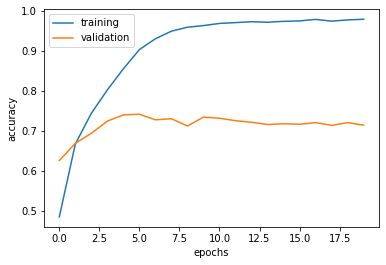

In [7]:
# TODO: plot the training and validation accuracy over epochs
def plot_from_history(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend(["training", "validation"])
  plt.show()

plot_from_history(history)

In [8]:
# Print the test accuracy after training
# NOTE: The test accuracy of our baseline model should be in the range 0.71-0.73
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 1s - loss: 2.1900 - accuracy: 0.7133 - 897ms/epoch - 3ms/step
0.7132999897003174


# Extending the model

In [9]:
# TODO: copy paste the baseline model from above

# TODO: add Batch Normalization to the model
# NOTE: where to add the Batch Normalization is an ongoing discussion
# different researchers argue that it is better to add it before or after the
# activation in the model. Read some of the discussions and decide for yourself:
# - https://arxiv.org/abs/1502.03167
# - https://www.reddit.com/r/MachineLearning/comments/2x0bq8/some_questions_regarding_batch_normalization/?su=ynbwk&st=iprg6e3w&sh=88bcbe40
# - https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras
# TODO: add Dropout to the model. Again research a bit on the internet and
# decide for yourself where you think adding the Dropout layer is best and with
# how much rate. Try different settings and decide what best works for you.

def create_model_dropout_batchnorm():
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:]))  # input_shape is (32, 32, 3)
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(32,(3, 3)))
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))

  model.add(layers.Conv2D(64, (3, 3), padding='same'))
  model.add(layers.Activation('relu'))

  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(64, (3,3)))
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())
 
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(rate=0.25))
 
  # model.add(layers.BatchNormalization()) 
  model.add(layers.Flatten())
  model.add(layers.Dropout(rate=0.25))
  model.add(layers.Dense(512))
  model.add(layers.Activation('relu'))

  model.add(layers.Dropout(rate=0.25))
  model.add(layers.BatchNormalization())

  model.add(layers.Dense(num_classes))
  return model


In [10]:
# Initialize and train the extended model
ext_model = create_model_dropout_batchnorm()

ext_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# TODO: add early stopping to the training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=5, restore_best_weights=True)

# NOTE: You can do this the easy or the hard way
# - the easy way just means defining the EarlyStopping callback from the keras
# api and using it in the call to fit
# - the hard way means writing your own training loop. If you want to learn how
# to this there is are simple examples here:
# - https://www.tensorflow.org/tutorials/quickstart/advanced
# - https://stackoverflow.com/questions/46428604/how-to-implement-early-stopping-in-tensorflow
# After having written your own training loop, you can easily implement the
# early stopping feature by stopping the loop when the validation loss or
# accuracy gets worse between iterations

# TODO: call ext_model.fit with early stopping
ext_history = ext_model.fit(x=train_images, y=train_labels, batch_size=32, epochs=20, callbacks=[early_stopping], validation_data=(val_images, val_labels))

Epoch 1/20
1250/1250 [==============================] - 9s 6ms/step - loss: 1.5422 - accuracy: 0.4632 - val_loss: 1.2270 - val_accuracy: 0.5583
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0908 - accuracy: 0.6150 - val_loss: 0.9402 - val_accuracy: 0.6649
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9269 - accuracy: 0.6765 - val_loss: 0.8526 - val_accuracy: 0.7032
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8307 - accuracy: 0.7069 - val_loss: 0.8179 - val_accuracy: 0.7156
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.7627 - accuracy: 0.7315 - val_loss: 0.7421 - val_accuracy: 0.7431
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7127 - accuracy: 0.7530 - val_loss: 0.7290 - val_accuracy: 0.7483
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6644 - accuracy: 0.7685 - val_loss: 0.6481 - val_accuracy:

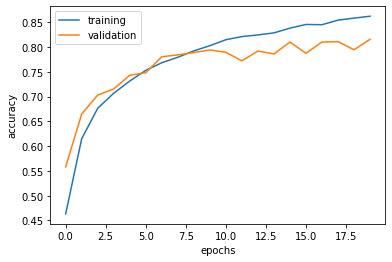

In [11]:
# TODO: plot the training and validation accuracy over epochs
plot_from_history(ext_history)

In [12]:
# Print the test accuracy after training
# NOTE: The test accuracy of our extended model should be above 0.805
test_loss, test_acc = ext_model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.5563 - accuracy: 0.8186 - 915ms/epoch - 3ms/step


#### TODO:

Answer the following questions:

- What does the `patience` parameter in the `tf.keras.callbacks.EarlyStopping` do? Why is it necessary and how does it help?  
  **The patience parameter prevents stopping directly when the monitored metric is not good enough. Only if the metric is lower than the peak for the defined epochs in patience the early stopping will kick in.**
- What is dropout method used for? Why does it help? Why doesn't it make the test accuracy worse?  
  **The dropout makes the neural network more resistant, because it "disables" a specified percentage of nodes in a layer. Therefore the network can't rely on certain nodes but has to use multiple.**
- Where did you position the BatchNorm layers and why?  
  **I did place it after every layer because someone said so and it works fine.**

# Data Augmentation

### Augmentation functions

The cell below includes two example transformations to be used for data augmentation. Use them as templates and inspiration for writing your own transformations.

In [36]:
# TODO: write two more image transformation functions
import random
from skimage import util

def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.01)
    x = tf.image.random_saturation(x, 0.9, 1.1)
    return x

def contrast(x: tf.Tensor) -> tf.Tensor:
    """Contrast augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_contrast(x, 0.5, 2)
    return x

def brightness(x: tf.Tensor) -> tf.Tensor:
    """Brightness augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_brightness(x, 0.5)
    return x

def flop(x: tf.Tensor) -> tf.Tensor:
    """Flop augmentation

    Args:
        x: Image to flop

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_up_down(x)

    return x

def crop(x: tf.Tensor) -> tf.Tensor:
  """Crop augmentation

  Args:
      x: Image

  Returns:
      Augmented image
  """
  ### Central crop ###

  # size = x.shape
  # x = tf.image.central_crop(x, 0.8)
  # x = tf.image.resize(x, [32, 32])
  # x = tf.image.convert_image_dtype(x, np.float64)

  ### Random Crop ###
  crop_size = tf.random.uniform(shape=(1,), minval=24, maxval=30, dtype=tf.int32)

  if len(x.shape) == 4:
    x = tf.map_fn(lambda image: tf.image.random_crop(image, size=[crop_size[0], crop_size[0], 3]), x)
  else:
    x = tf.image.random_crop(x, size=[crop_size[0], crop_size[0], 3])
  x = tf.image.resize(x, [32, 32])
  x = tf.image.convert_image_dtype(x, np.float64)

  return x


def rotate(x: tf.Tensor) -> tf.Tensor:
  """Rotate augmentation

  Args:
      x: Image

  Returns:
      Augmented image
  """
  x = tf.image.rot90(x, k=random.randrange(1,4))
  return x

def noise(x: tf.Tensor) -> tf.Tensor:
  """Noise augmentation

  Args:
      x: Image

  Returns:
      Augmented image
  """
  # x = util.random_noise(x)
  noise = tf.random.uniform(shape=tf.shape(x), minval=-0.05, maxval=0.05, dtype=tf.float64)
  x = tf.add(x, noise)
  return x



### Dataset augmentation, training and evaluation

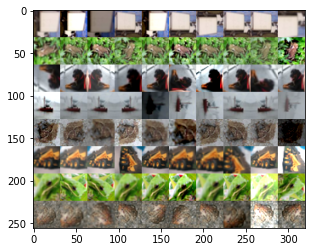

In [40]:
# First let us visualise the image transformations we defined above.

def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()


# We will use the Dataset api for easier mapping of image transformations to the
# CIFAR10 dataset. Here we only use the first 8 images from the dataset to
# visualize our transformations

dataset = tf.data.Dataset.from_tensor_slices(train_images).take(8)

augmentations = [flip, color, contrast, flop, brightness, rotate, crop]

for f in augmentations:
    # NOTE: we are aplying the transformation 75% of the time
    dataset = dataset.map(lambda x: tf.cond(tf.random.uniform([], 0, 1) > 0.75, 
                                            lambda: f(x), 
                                            lambda: x), num_parallel_calls=4)

# Transformations might make the pixel values go out of range so we clip them
dataset = dataset.map(lambda x: tf.clip_by_value(x, 0, 1))

plot_images(dataset, n_images=8, samples_per_image=10)

In [41]:
# Now we use the Dataset api on the whole training and validation set
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

# Add the augmentations
for f in augmentations:
    # NOTE: Feel free to change the probability of the augmentation
    f_aug = lambda x, y: (tf.cond(tf.random.uniform([], 0, 1) > 0.75,
                                  lambda: f(x),
                                  lambda: x), y)
    train_dataset = train_dataset.map(f_aug)
train_dataset = train_dataset.map(lambda x, y: (tf.clip_by_value(x, 0, 1), y))

# We use the baseline model here because we want to compare the test accuracy of
# data augmentation approach with the extended model!
aug_model = create_model()

aug_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = aug_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.8361 - accuracy: 0.3306 - val_loss: 1.4595 - val_accuracy: 0.4725
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5061 - accuracy: 0.4594 - val_loss: 1.1638 - val_accuracy: 0.5917
Epoch 3/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3076 - accuracy: 0.5334 - val_loss: 1.0277 - val_accuracy: 0.6461
Epoch 4/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1752 - accuracy: 0.5859 - val_loss: 0.9459 - val_accuracy: 0.6696
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0969 - accuracy: 0.6105 - val_loss: 0.8809 - val_accuracy: 0.6931
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0250 - accuracy: 0.6389 - val_loss: 0.9260 - val_accuracy: 0.6889
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9978 - accuracy: 0.6498 - val_loss: 0.8282 - val_accuracy:

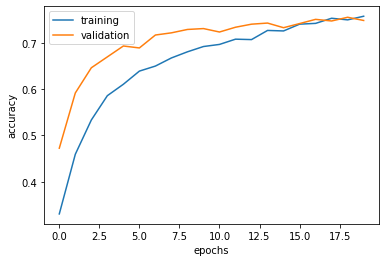

313/313 - 1s - loss: 0.8307 - accuracy: 0.7497 - 891ms/epoch - 3ms/step
0.7497000098228455


In [42]:
# TODO: plot the training and validation accuracy over epochs
plot_from_history(history)

# Print the test accuracy after training
# NOTE: The test accuracy of our model with data augmentation (including your
# added augmentations) should be at least above 0.745
test_loss, test_acc = aug_model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

#### TODO:

Answer the following questions:

- How does the data augmentation help improve the accuracy of the model?  
  **Data/Image augmentation is used as a regularizer to reduce overfitting by mildly changing the appearance of the data to increase the sample variety.**
- What would be the optimal data augmentation for a specific task?  
  **It depends. [This paper](https://journalofbigdata.springeropen.com/counter/pdf/10.1186/s40537-019-0197-0.pdf) says that cropping has the best improvements, but also states that the usefulness of the augmentations depends on the training data (e. g. flipping is not recommended on MNIST (2 vs 5)). It must also be ensured that the augmentation does not change the true label.**
- Which of the methods we used so far (dropout, batch norm, early stopping, data augmentation) improved the accuracy the most? Support you answer with data. Discuss the potential reasons why did this method improve the accuracy more than other methods?